In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import os


In [2]:
df = pd.read_csv('../data/icicibank.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')


In [3]:
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['SMA7'] = df['Close'].rolling(window=7).mean()
df['SMA21'] = df['Close'].rolling(window=21).mean()
df.dropna(inplace=True)


In [4]:
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'SMA7', 'SMA21']
X = df[features]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [5]:
model = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=12, n_estimators=300, random_state=42)

In [6]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 46.74
RMSE: 65.83
R² Score: 0.41


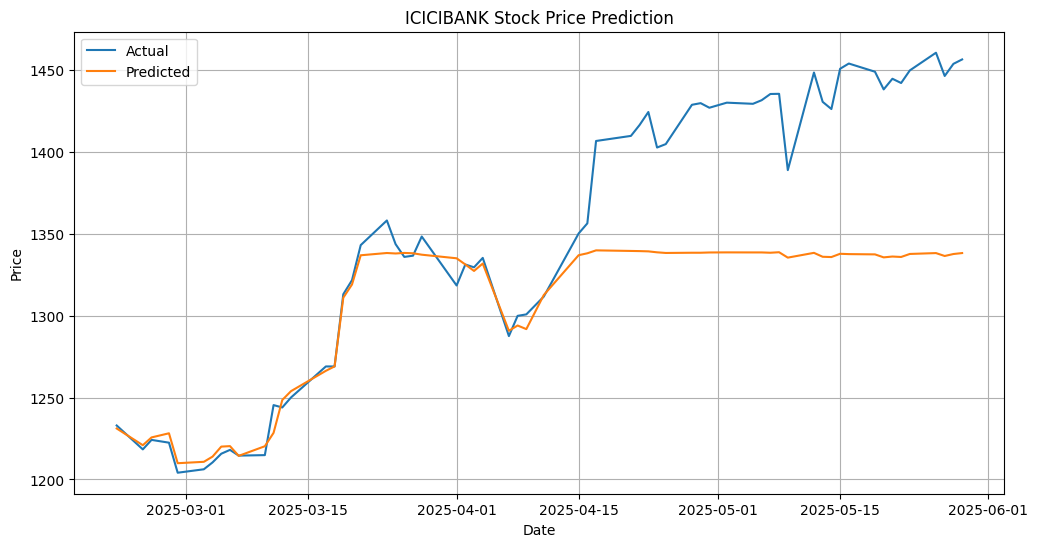

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted')
plt.title("ICICIBANK Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()


✅ Improved Feature Engineering + XGBoost Model
This new approach adds:

📅 Time-based features (Day of Week, Month)

💹 Lagged returns & rolling volatility

🚀 Replaces RandomForest with XGBoost (strong with tabular trends)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle, os


In [9]:
df = pd.read_csv('../data/icicibank.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')


In [10]:
# Technical indicators
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['SMA7'] = df['Close'].rolling(window=7).mean()
df['SMA21'] = df['Close'].rolling(window=21).mean()

# Time-based features
df['Day'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Lagged returns
df['Return_1d'] = df['Close'].pct_change(1)
df['Return_3d'] = df['Close'].pct_change(3)

# Rolling Volatility
df['Volatility_5d'] = df['Close'].rolling(window=5).std()

df.dropna(inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_9328\1375676966.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df['Return_1d'] = df['Close'].pct_change(1)
C:\Users\hp\AppData\Local\Temp\ipykernel_9328\1375676966.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df['Return_3d'] = df['Close'].pct_change(3)


In [11]:
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'SMA7', 'SMA21',
            'Day', 'Month', 'Return_1d', 'Return_3d', 'Volatility_5d']
X = df[features]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.9)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 46.96
RMSE: 66.42
R² Score: 0.40


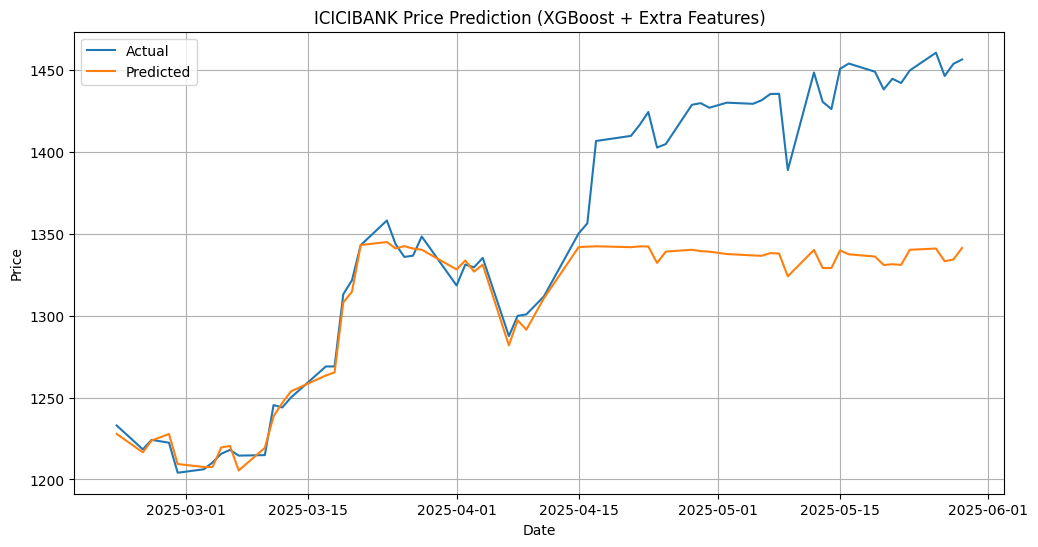

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted')
plt.title("ICICIBANK Price Prediction (XGBoost + Extra Features)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [18]:
import yfinance as yf

start = '2010-01-01'
end = '2025-05-30'
data = yf.download("ICICIBANK.NS", start=start, end=end)
data.to_csv('../data/icicibank_long.csv')


Failed to get ticker 'ICICIBANK.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ICICIBANK.NS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [ ]:
os.makedirs('../models', exist_ok=True)
with open('../models/icicibank.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved as ../models/icicibank.pkl")
